In [1]:
from qiskit import QuantumCircuit, QuantumRegister, BasicAer, execute
from qiskit.ignis.verification import process_tomography_circuits, ProcessTomographyFitter
from qiskit.quantum_info import Choi, partial_trace

import numpy as np

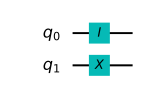

In [2]:
q = QuantumRegister(2, name='q')
circuit = QuantumCircuit(q)

circuit.id(0)
circuit.x(1)

%config InlineBackend.figure_format = 'svg'
circuit.draw(output='mpl', scale=0.5)

In [3]:
#rho: density matrix 2X2
#chi: process matrix 4X4
def superoperator(rho, chi):
    return [[rho[0][0]*chi[0][0] + rho[0][1]*chi[0][1] + rho[1][0]*chi[1][0] + rho[1][1]*chi[1][1],
            rho[0][0]*chi[0][2] + rho[0][1]*chi[0][3] + rho[1][0]*chi[1][2] + rho[1][1]*chi[1][3]],
           [rho[0][0]*chi[2][0] + rho[0][1]*chi[2][1] + rho[1][0]*chi[3][0] + rho[1][1]*chi[3][1],
            rho[0][0]*chi[2][2] + rho[0][1]*chi[2][3] + rho[1][0]*chi[3][2] + rho[1][1]*chi[3][3]]]

In [4]:
#chi_id: ideal process matrix for 2-qubit circuit
#sys: subsystem to trace out {0, 1}
def trace_out(chi_id, sys):
    return partial_trace(chi_id.data, [sys,sys+2]).data / 2

In [5]:
#chi_id: ideal process matrix 4X4
#chi_ex: experimental process matrix 4X4
def process_fidelity(chi_id, chi_ex): 
    return np.trace(np.transpose(np.conjugate(chi_id)).dot(chi_ex))/4

In [6]:
backend = BasicAer.get_backend('qasm_simulator')

In [7]:
#Identity superoperator fidelity

circuits = process_tomography_circuits(circuit, [0])
results = execute(circuits, shots=10000, backend=backend).result()

fitter = ProcessTomographyFitter(results, circuits)

chi_ex = fitter.fit().data # experimental
chi_id = trace_out(Choi(circuit), 1) # ideal

process_fidelity(chi_id, chi_ex)

(0.9984365091019247+0j)

In [8]:
#Not superoperator fidelity

circuits = process_tomography_circuits(circuit, [1])
results = execute(circuits, shots=10000, backend=backend).result()

fitter = ProcessTomographyFitter(results, circuits)

chi_ex = fitter.fit().data # experimental
chi_id = trace_out(Choi(circuit), 0) # ideal

process_fidelity(chi_id, chi_ex)

(0.9965760022133627+0j)